# Source of Inspiration
For this iteration of my project, I was intersted in different ways that others pre-processed the data. My intuition in the first iteration of the project didn't actually lead to an improvement of performance for my model. As a result, I wanted to look at what other people had done in terms of pre-processing the data and adding new features. 

One script that I found in the Kaggle scripts section was this [Random Forest Script](https://www.kaggle.com/amoyakd/titanic/randomforest-method-v1-0). In this script, the author does quite a bit of pre-processing. This script, however, was written in R, so I'm going to try to replicate this pre-processing work in Python. 

Although they used random forrests in this script to do the learning, I wanted to use linear regression. The reason that I'm doing this is that I didn't want to use a model that I didn't quite understand -- this wouldn't tell me if my score improvements (or declines) were a result of the model or the new features I created. 

In [32]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

First, they read in the data.

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

Next is cleaning the data. In this particular script, the author mostly does something very similar to what we did in the previous tutorial for the sex and embarked and fare columns.

In [3]:
# Recode Sex data
test.loc[test["Sex"] == "male", "Sex"] = 0
test.loc[test["Sex"] == "female", "Sex"] = 1
train.loc[train["Sex"] == "male", "Sex"] = 0
train.loc[train["Sex"] == "female", "Sex"] = 1

# Recode Embarked Data
test["Embarked"] = test["Embarked"].fillna("S")
test.loc[test["Embarked"] == "S", "Embarked"] = 0
test.loc[test["Embarked"] == "C", "Embarked"] = 1
test.loc[test["Embarked"] == "Q", "Embarked"] = 2

train["Embarked"] = train["Embarked"].fillna("S")
train.loc[train["Embarked"] == "S", "Embarked"] = 0
train.loc[train["Embarked"] == "C", "Embarked"] = 1
train.loc[train["Embarked"] == "Q", "Embarked"] = 2

#Replace one missing fare data
test["Fare"] = test["Fare"].fillna(train["Fare"].median())


Now, in this script, we also extract the title from the name of the person. 

In [4]:
def extractTitle (name):
    title = re.findall(r', \w+\s?\w*\.', name)[0][2:-1]
    if (title in ['Don','Lady','the Countess', 'Jonkheer']):
        return 'Lady'
    elif (title in ['Capt', 'Don', 'Major', 'Sir']):
        return 'Sir'
    
    return title 

In [5]:
train["Title"] = train['Name'].apply(lambda x: extractTitle(x))
test["Title"] = test['Name'].apply(lambda x: extractTitle(x))

titles = train["Title"].unique()

titleColumns = []
for title in titles:
    train["Title" + title] = train["Title"].apply(lambda x: int(x == title))
    test["Title" + title] = test["Title"].apply(lambda x: int(x == title))
    titleColumns.append("Title" + title)

Now, using the title, class, sex, sibsp, parch, and fare data, we run a regression to predict the age. I thought that this was a particularly interesting method of filling in missing age values. We had briefly talked about other methods for filling in missing age values other than just adding in the median value for age. I was really curious about other methods, so I'm very interested in trying this method. 

In this particular script, they used both the training and the testing data to fit a regression for age. I wasn't sure about whether it's okay to use the testing set to also fit a regression for age. Is that okay? To be safe, I just used the training set. 

In [6]:
#First, we want to select all of the non-null training values so that we can run our regression
ageFilledTrain = train.dropna(subset = titleColumns + ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'])
ageXTrain = ageFilledTrain[titleColumns + ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
ageYTrain = ageFilledTrain['Age']

#Also extract the filled test data (we'll use this for later)
ageFilledTest = test.dropna(subset = titleColumns + ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'])

#Now, we fit a linear regression
regr = LinearRegression()
regr.fit(ageXTrain, ageYTrain)

#Now, we want to predict the missing ages
nullAgesTrain = train[train['Age'].isnull()]
nullAgesTrain['Age'] = regr.predict(nullAgesTrain[titleColumns + ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']])
nullAgesTest = test[test['Age'].isnull()]
nullAgesTest['Age'] = regr.predict(nullAgesTest[titleColumns + ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']])


#Now, we want to add these back in to the dataframe. (I'm sure that there is a better way to do this!)
#I am not proud of concatening these back together... How do I do this better?
train = pd.concat([ageFilledTrain, nullAgesTrain])
test = pd.concat([ageFilledTest, nullAgesTest])

/Users/Sophia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Sophia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, to continue cleaning the data and recoding fields, we also add a family size and a mother/child  field.

In [7]:
#Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

#Adding a mother flag
train['Mother'] = ((train['Sex'] == 1) 
                   & (train['Parch'] > 0) 
                   & (train['Age'] > 18)
                   & (train['Title'] != 'Miss'))
test['Mother'] = ((test['Sex'] == 1) 
                   & (test['Parch'] > 0) 
                   & (test['Age'] > 18)
                   & (test['Title'] != 'Miss'))

#Adding a child flag
train['Child'] = ((train['Parch'] > 0) 
                   & (train['Age'] < 18))

test['Child'] = ((test['Parch'] > 0) 
                   & (test['Age'] < 18))

This model also created a family ID field. I wasn't sure about this -- it seems like this field would divide the data up too much, and it doesn't really make sense to have the id encoded as something linear. Also, I wonder how much of this information can be encoded within the fields that have the number of family memebers on board. As a result, I didn't replicate this field in my iteration two. 

Next, this author also extracted the cabin number as well as deck from the data. I will do that as well. 

In [8]:
def recodeCabinToDeck(cabin):
    if isinstance(cabin, str):
        if (cabin[0] == 'A'):
            return 1
        elif (cabin[0] == 'B'):
            return 2
        elif (cabin[0] == 'C'):
            return 3
        elif (cabin[0] == 'D'):
            return 4
        elif (cabin[0] == 'E'):
            return 5
        elif (cabin[0] == 'F'):
            return 6
        elif (cabin[0] == 'G'):
            return 7
        else:
            return 0
    else:
        return 0
            

def extractCabinNumber(cabin):
    if isinstance(cabin, str):
        cabinNum = re.findall(r'\d+',cabin)
        if len(cabinNum) > 0:
            return int(cabinNum[0])
        else:
            return 0
    else:
        return 0
    

In [9]:
train['DeckRecode'] = train.Cabin.apply(lambda x: recodeCabinToDeck(x))
test['DeckRecode'] = test.Cabin.apply(lambda x: recodeCabinToDeck(x))

train['CabinNumber'] = train.Cabin.apply(lambda x: extractCabinNumber(x))
test['CabinNumber'] = test.Cabin.apply(lambda x: extractCabinNumber(x))

Now, we need to split our train data into a testing/training set. 

In [42]:
useColumns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Mother', 'Child', 
              'FamilySize', 'DeckRecode', 'CabinNumber', 'Embarked'] + titleColumns
X_train, X_test, y_train, y_test = train_test_split(train[useColumns], train['Survived'], test_size = 0.5)

Now, we want to create our linear regression. 

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
y_predict[y_predict > .5] = 1
y_predict[y_predict <=.5] = 0

accuracy = sum([y_predict[i] == y_test.tolist()[i] for i in range(len(y_predict))])/float(len(y_predict))
print accuracy

0.854260089686


Hey, that's not so bad! I'm going to use this to generate another submission to Kaggle

In [44]:
submissionModel = LinearRegression()
submissionModel.fit(train[useColumns], train['Survived'])

predictions = submissionModel.predict(test[useColumns])

predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions.astype(int)
    })

submission.to_csv("kaggle_it2_0.csv", index=False)

With this model, I scored a 0.78947, which improved my best score! Yay!

# What actually happened? Why is this model better?
So, it does seem that this method of adding new features is an improvment. Now, I'm curious -- which features are the most predicive, and which just serve to confuse the model further?

First, let's just plot the weights of the features

(-1, 25)

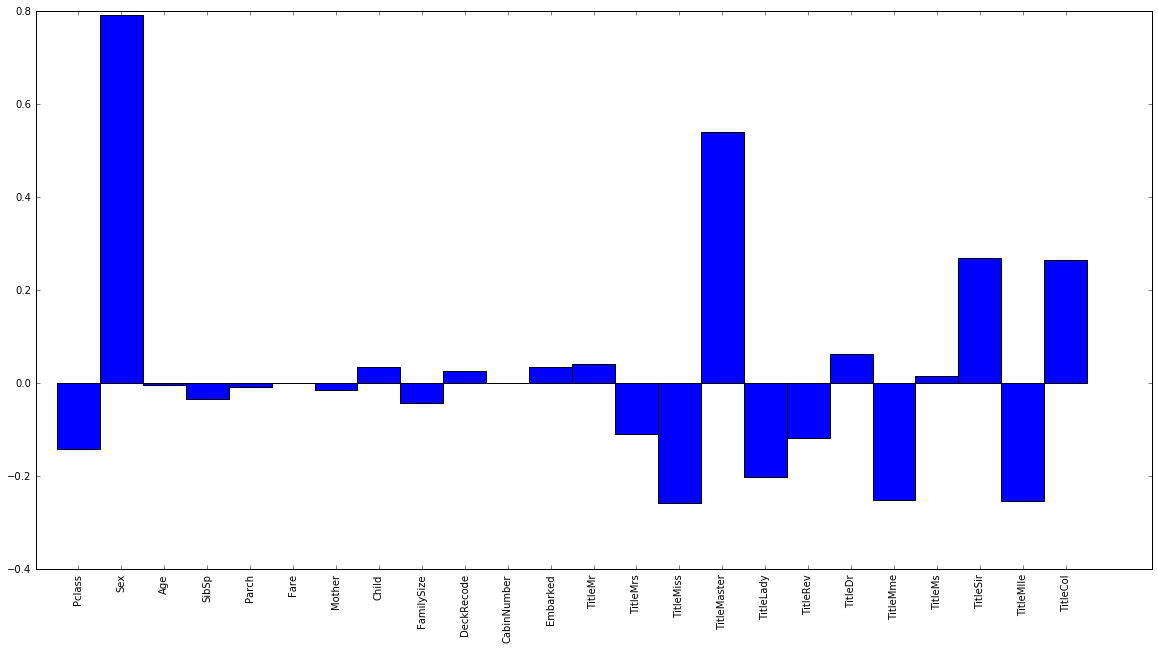

In [45]:
coefs = submissionModel.coef_
plt.figure(figsize=(20,10))
plt.bar([x - 0.5 for x in range(len(coefs))],coefs, width = 1)
plt.xticks(range(len(coefs)), useColumns, rotation='vertical')
plt.xlim(-1, len(coefs) + 1)

Interesting... So, it seems like sex is, unsurprisingly, thge biggest predictor of survival. But, after this, I was surprised by the weights that the model learned. I was expecting age to receive a fairly high magnitude weight, and it does not appear that that actually happened. 

In fact, it appears that the 'Title Master' column is the next best predictor of survival. I looked more into the title itself, and according to [wikipedia](https://en.wikipedia.org/wiki/Master_(form_of_address)), "Master is an English honorific for boys and young men.". So, it appears that the model didn't pick up on age, but did pick up that boys and young men were more likely to survive. Similarly, it appears that younger girls (who have the title "Miss") were less likely to survive. It is interesting to me that this model appears to pick up age (and to some extent class) more in the titles than it does in the actual passenger age and class columns. This is interesting to me because I wasn't actually expecting to have the titles really affect the model that much. 

It appears, however, that the deck recode and the cabin number don't have that much affect. 

# Future Work

If I were going to improve this model, I'd go through and pull out only the most informative features, and then run the model again, seeing if this improved the score. The idea is that we likely have some features that are distracting the model so that we should use only the most informative features for this model, maybe by selecting only the features that are above some threshold. 

I also would be curious whether implementing the family id field actually boosts performance. 

One thing that I've wondered about for datasets like this: does it ever really make sense to split the dataset and learn two separate models. For example, I imagine that you might be able to learn a separate model, with different weights for women and men. Is this ever beneficial, or is it always better to have as much data as possible?

I'm also curious: how much does using a different kind of model (logistic vs linear regresssion vs random forrest) affect the score? Are there certain models that are particularly good at solving certain problems. (Why?) So, another thing tha